In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from skimage.feature import hog, graycomatrix, graycoprops
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, cohen_kappa_score
from tqdm import tqdm


In [6]:
def load_images_from_folder(dataset_path, img_size=(128, 128)):
    images, labels = [], []
    class_mapping = {}
    
    for idx, folder in enumerate(sorted(os.listdir(dataset_path))):
        folder_path = os.path.join(dataset_path, folder)
        if not os.path.isdir(folder_path):
            continue
        class_mapping[idx] = folder
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, img_size)
                images.append(img)
                labels.append(idx)
    
    return np.array(images), np.array(labels), class_mapping

# Dataset path
dataset_path = r"C:\Users\kamep\Downloads\Ml contents\Dataset normal"
images, labels, class_mapping = load_images_from_folder(dataset_path)
print(f"✅ Loaded {len(images)} images across {len(class_mapping)} classes")


✅ Loaded 105115 images across 91 classes


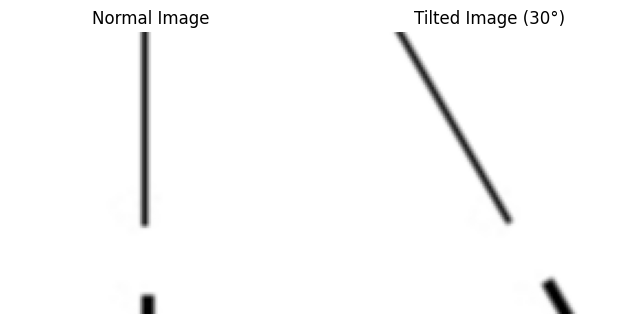

In [7]:
def show_tilt_example(image, angle=30):
    h, w = image.shape
    M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1)
    tilted_img = cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_REPLICATE)
    
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(image, cmap='gray')
    plt.title("Normal Image")
    plt.axis('off')
    
    plt.subplot(1,2,2)
    plt.imshow(tilted_img, cmap='gray')
    plt.title(f"Tilted Image ({angle}°)")
    plt.axis('off')
    
    plt.show()

# Show example (random image from dataset)
show_tilt_example(images[0], angle=30)


In [8]:
def augment_images_with_rotation(images, angle_range=30):
    augmented_images = []
    for img in images:
        angle = np.random.uniform(-angle_range, angle_range)
        h, w = img.shape
        M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1)
        rotated_img = cv2.warpAffine(img, M, (w, h), borderMode=cv2.BORDER_REPLICATE)
        augmented_images.append(rotated_img)
    return np.array(augmented_images)

# Apply augmentation
tilted_images = augment_images_with_rotation(images, angle_range=30)
print(f"✅ Augmented {len(tilted_images)} images with random rotation ±30°")


✅ Augmented 105115 images with random rotation ±30°


In [9]:
# HOG Features
def extract_hog_features(images):
    features = []
    for img in tqdm(images, desc="Extracting HOG"):
        feat = hog(img, orientations=9, pixels_per_cell=(8,8),
                   cells_per_block=(2,2), block_norm='L2-Hys', visualize=False)
        features.append(feat)
    return np.array(features)

# GLCM Features
def extract_glcm_features(images):
    features = []
    for img in tqdm(images, desc="Extracting GLCM"):
        glcm = graycomatrix(img, [1], [0], symmetric=True, normed=True)
        contrast = graycoprops(glcm, 'contrast')[0,0]
        dissimilarity = graycoprops(glcm, 'dissimilarity')[0,0]
        homogeneity = graycoprops(glcm, 'homogeneity')[0,0]
        energy = graycoprops(glcm, 'energy')[0,0]
        correlation = graycoprops(glcm, 'correlation')[0,0]
        features.append([contrast, dissimilarity, homogeneity, energy, correlation])
    return np.array(features)

# SIFT Features
def extract_sift_features(images, max_features=100):
    sift = cv2.SIFT_create()
    features = []
    for img in tqdm(images, desc="Extracting SIFT"):
        keypoints, descriptors = sift.detectAndCompute(img, None)
        if descriptors is not None:
            descriptors = descriptors.flatten()[:max_features]
        else:
            descriptors = np.zeros(max_features)
        if descriptors.shape[0] < max_features:
            descriptors = np.pad(descriptors, (0, max_features - descriptors.shape[0]))
        features.append(descriptors)
    return np.array(features)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    tilted_images, labels, test_size=0.2, random_state=42, stratify=labels
)

# Extract features for tilted data
X_train_hog = extract_hog_features(X_train)
X_test_hog = extract_hog_features(X_test)

X_train_glcm = extract_glcm_features(X_train)
X_test_glcm = extract_glcm_features(X_test)

X_train_sift = extract_sift_features(X_train)
X_test_sift = extract_sift_features(X_test)


Extracting SIFT: 100%|██████████████████████████████████████████████████████████| 21023/21023 [02:38<00:00, 132.69it/s]


In [8]:
def evaluate_model(X_train, X_test, y_train, y_test, feature_name, class_mapping):
    print(f"\n========== {feature_name} + Decision Tree ==========")

    model = DecisionTreeClassifier(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}")
    print(f"Cohen's Kappa: {kappa:.4f}")

    # Classification Report
    unique_labels = np.unique(np.concatenate([y_test, y_pred]))
    print("\nClassification Report:")
    print(classification_report(
        y_test, y_pred,
        labels=unique_labels,
        target_names=[class_mapping[i] for i in unique_labels],
        zero_division=0
    ))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=unique_labels)
    num_classes = len(unique_labels)
    plt.figure(figsize=(max(14, num_classes*0.8), max(12, num_classes*0.8)))
    sns.heatmap(
        cm, annot=True, fmt='d', cmap="Blues",
        xticklabels=[class_mapping[i] for i in unique_labels],
        yticklabels=[class_mapping[i] for i in unique_labels],
        cbar=True, linewidths=1.8, linecolor='gray',
        annot_kws={"size": 14, "weight": "bold"}
    )
    plt.xticks(rotation=45, fontsize=14, weight="bold")
    plt.yticks(rotation=0, fontsize=14, weight="bold")
    plt.title(f"{feature_name} + Decision Tree Confusion Matrix", fontsize=18, weight="bold", pad=20)
    plt.xlabel("Predicted", fontsize=16, weight="bold", labelpad=15)
    plt.ylabel("True", fontsize=16, weight="bold", labelpad=15)
    plt.tight_layout()
    plt.show()

    return acc



========== HOG + Decision Tree ==========
Accuracy: 0.4363
Cohen's Kappa: 0.4288

Classification Report:
               precision    recall  f1-score   support

            !       0.58      0.67      0.62       260
            (       0.59      0.64      0.61       300
            )       0.62      0.61      0.62       300
            +       0.21      0.24      0.23       300
            ,       0.34      0.39      0.36       300
            -       0.74      0.76      0.75       300
            0       0.51      0.50      0.50       300
            1       0.16      0.17      0.16       300
            2       0.23      0.24      0.24       300
            3       0.38      0.36      0.37       300
            4       0.21      0.21      0.21       300
            5       0.33      0.30      0.31       300
            6       0.46      0.45      0.46       300
            7       0.35      0.38      0.36       300
            8       0.36      0.36      0.36       300
            9

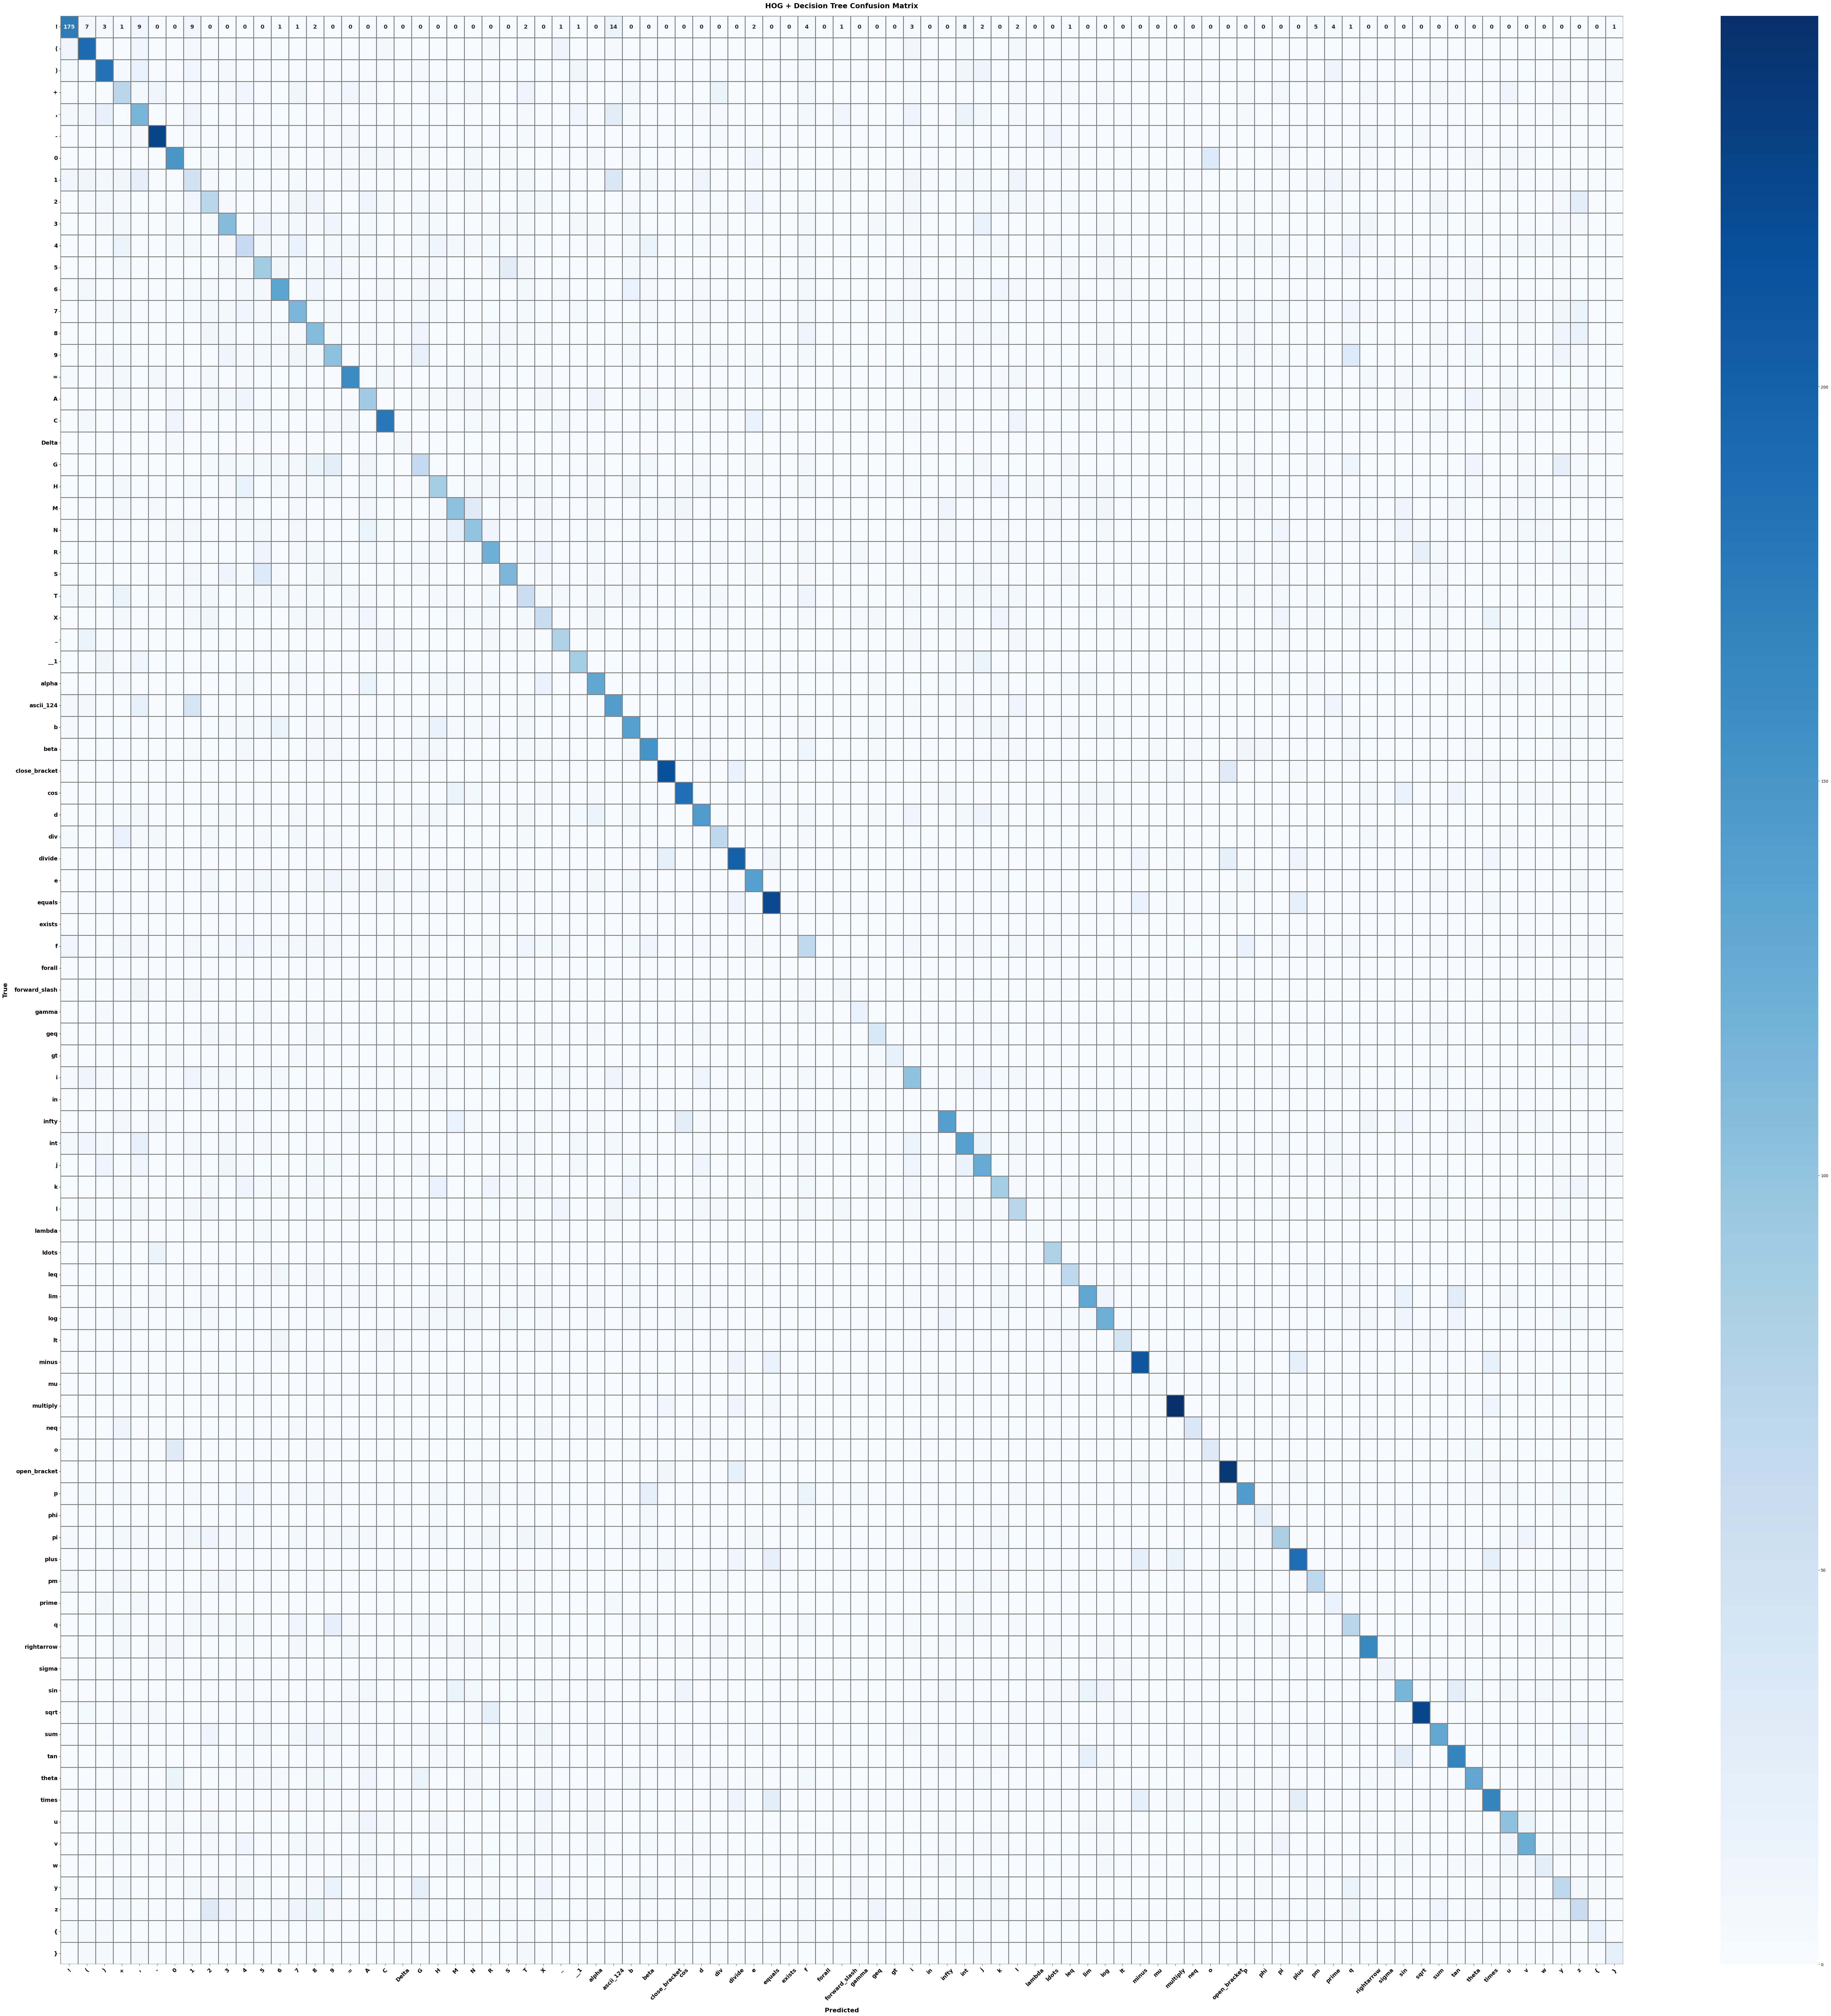


========== GLCM + Decision Tree ==========
Accuracy: 0.2792
Cohen's Kappa: 0.2696

Classification Report:
               precision    recall  f1-score   support

            !       0.75      0.74      0.74       260
            (       0.28      0.30      0.29       300
            )       0.38      0.38      0.38       300
            +       0.22      0.21      0.22       300
            ,       0.36      0.36      0.36       300
            -       0.89      0.88      0.89       300
            0       0.11      0.11      0.11       300
            1       0.15      0.13      0.14       300
            2       0.07      0.07      0.07       300
            3       0.14      0.15      0.14       300
            4       0.07      0.06      0.07       300
            5       0.09      0.08      0.08       300
            6       0.13      0.14      0.14       300
            7       0.12      0.12      0.12       300
            8       0.22      0.23      0.23       300
            

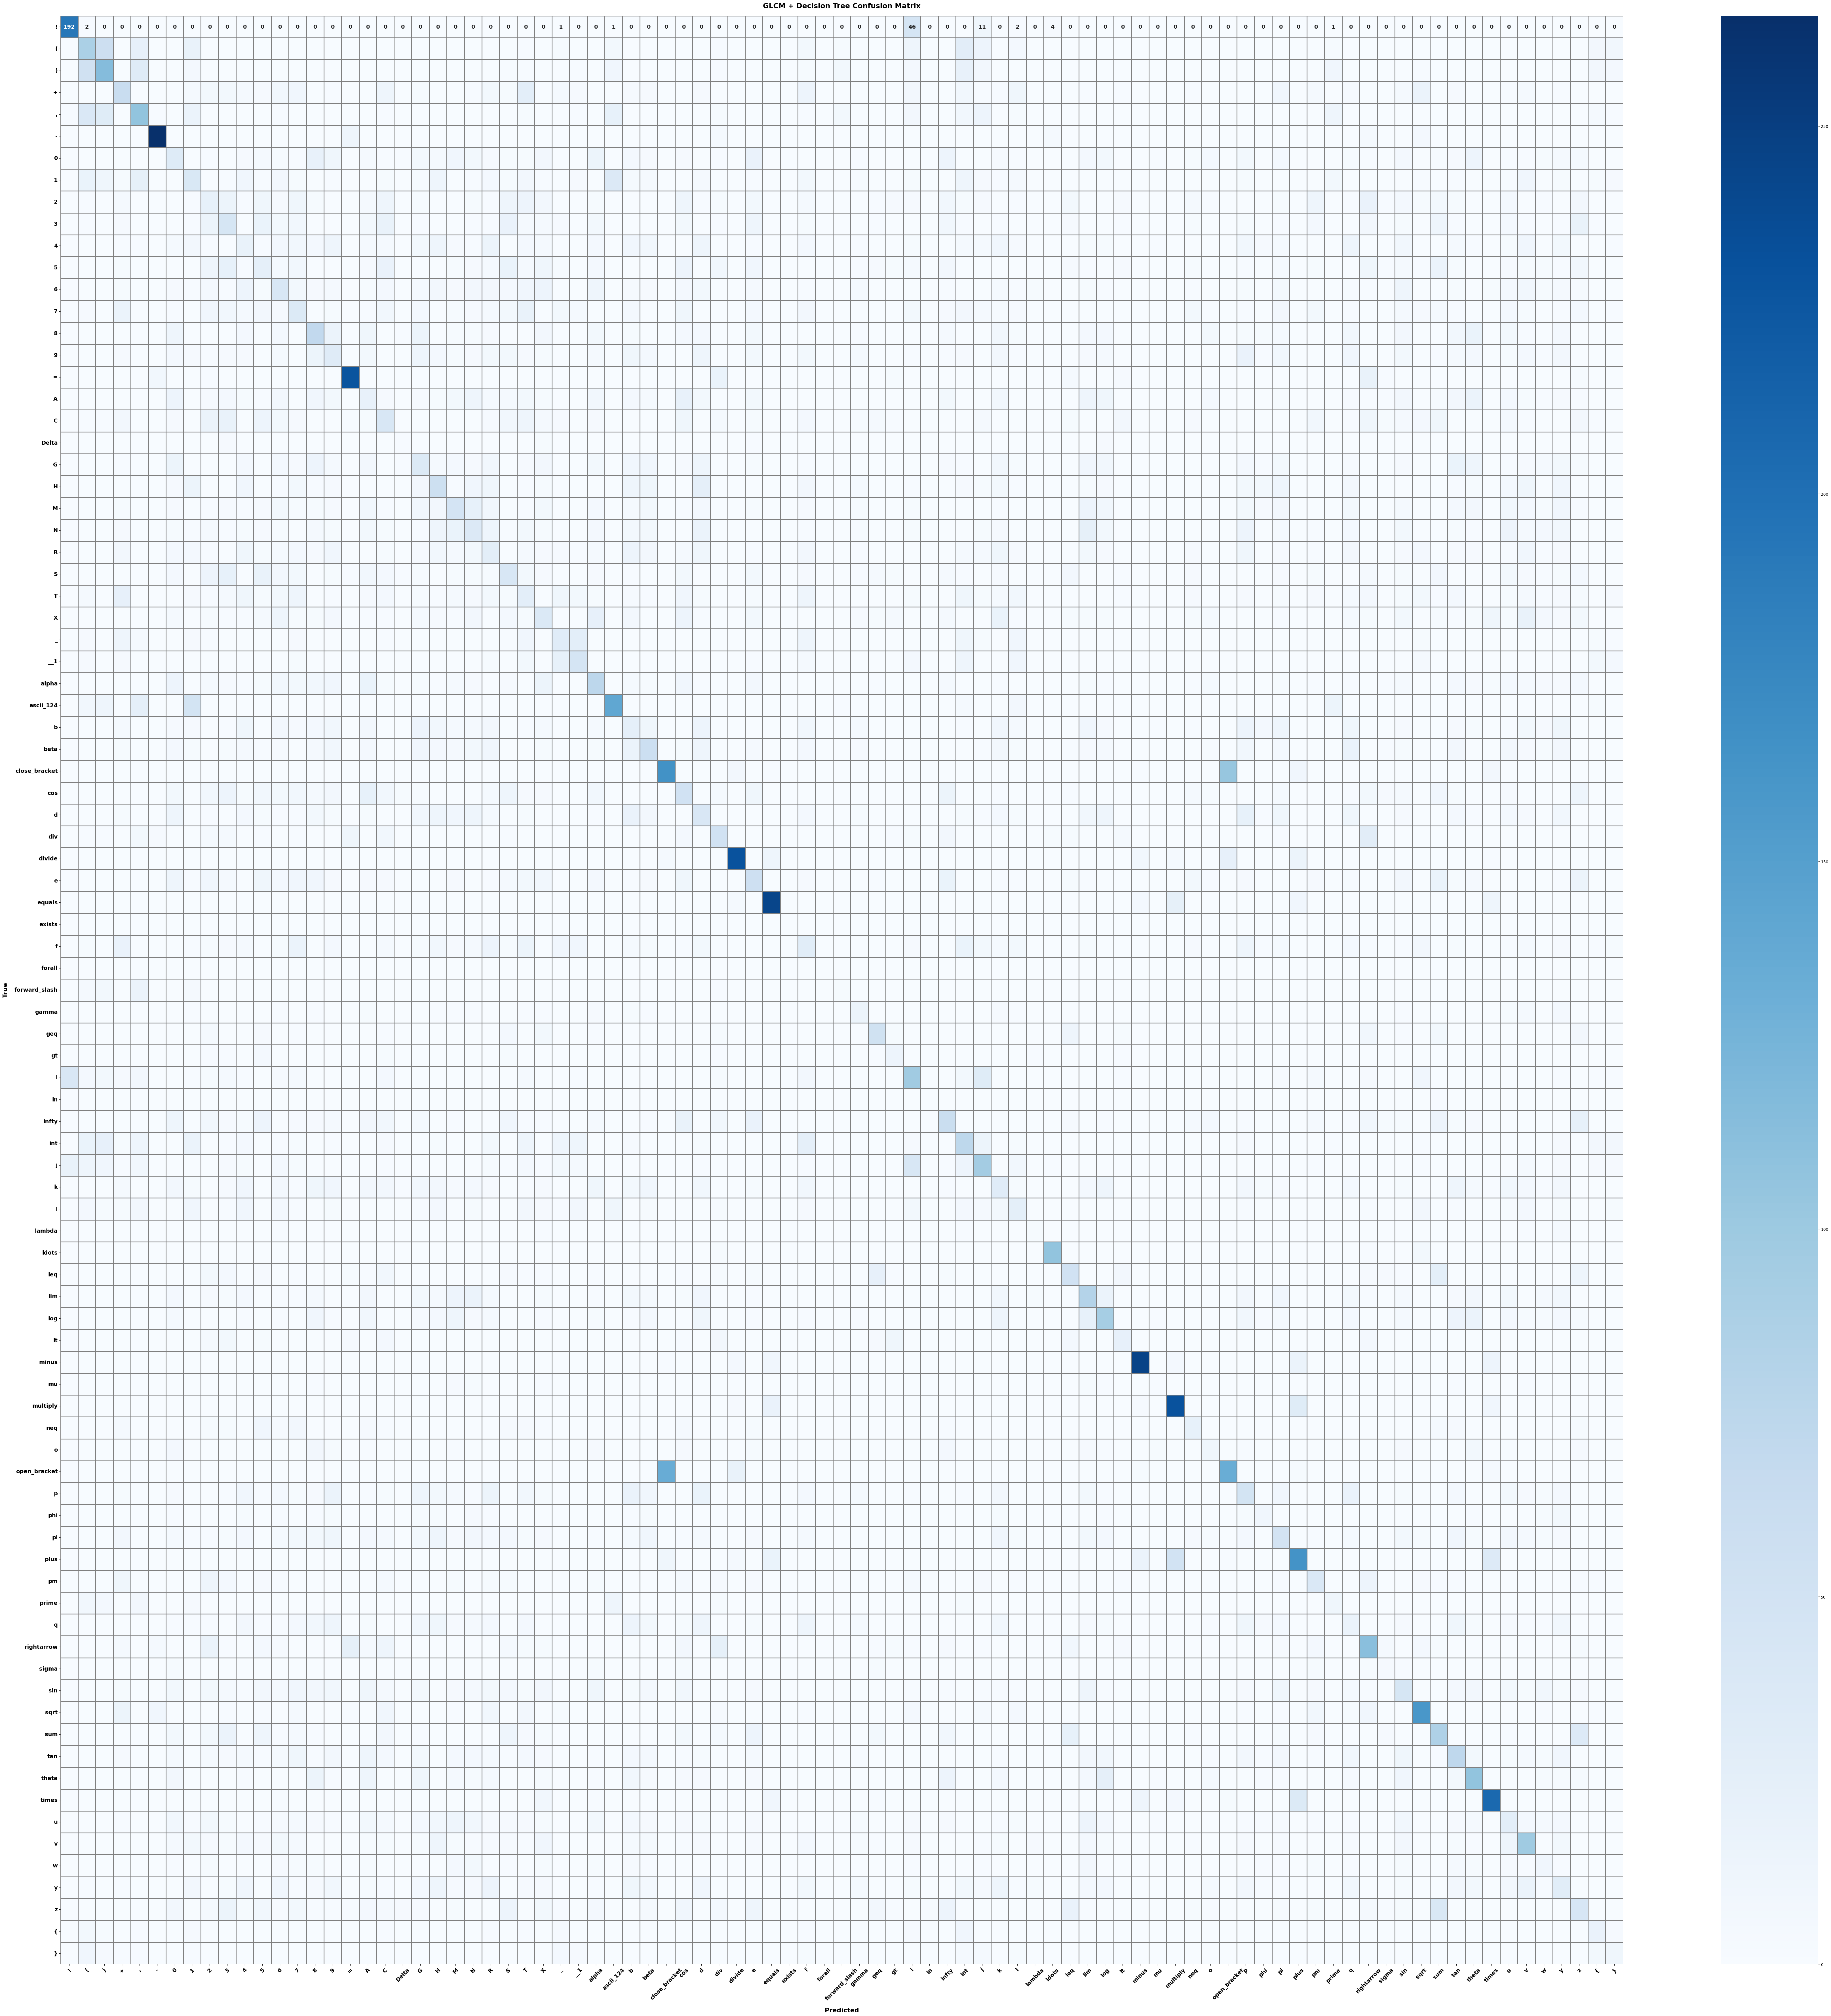


========== SIFT + Decision Tree ==========
Accuracy: 0.1181
Cohen's Kappa: 0.1063

Classification Report:
               precision    recall  f1-score   support

            !       0.18      0.18      0.18       260
            (       0.12      0.13      0.12       300
            )       0.17      0.19      0.18       300
            +       0.07      0.07      0.07       300
            ,       0.12      0.12      0.12       300
            -       0.12      0.10      0.11       300
            0       0.04      0.04      0.04       300
            1       0.04      0.04      0.04       300
            2       0.05      0.05      0.05       300
            3       0.10      0.11      0.11       300
            4       0.07      0.07      0.07       300
            5       0.08      0.07      0.07       300
            6       0.08      0.09      0.09       300
            7       0.07      0.07      0.07       300
            8       0.06      0.06      0.06       300
            

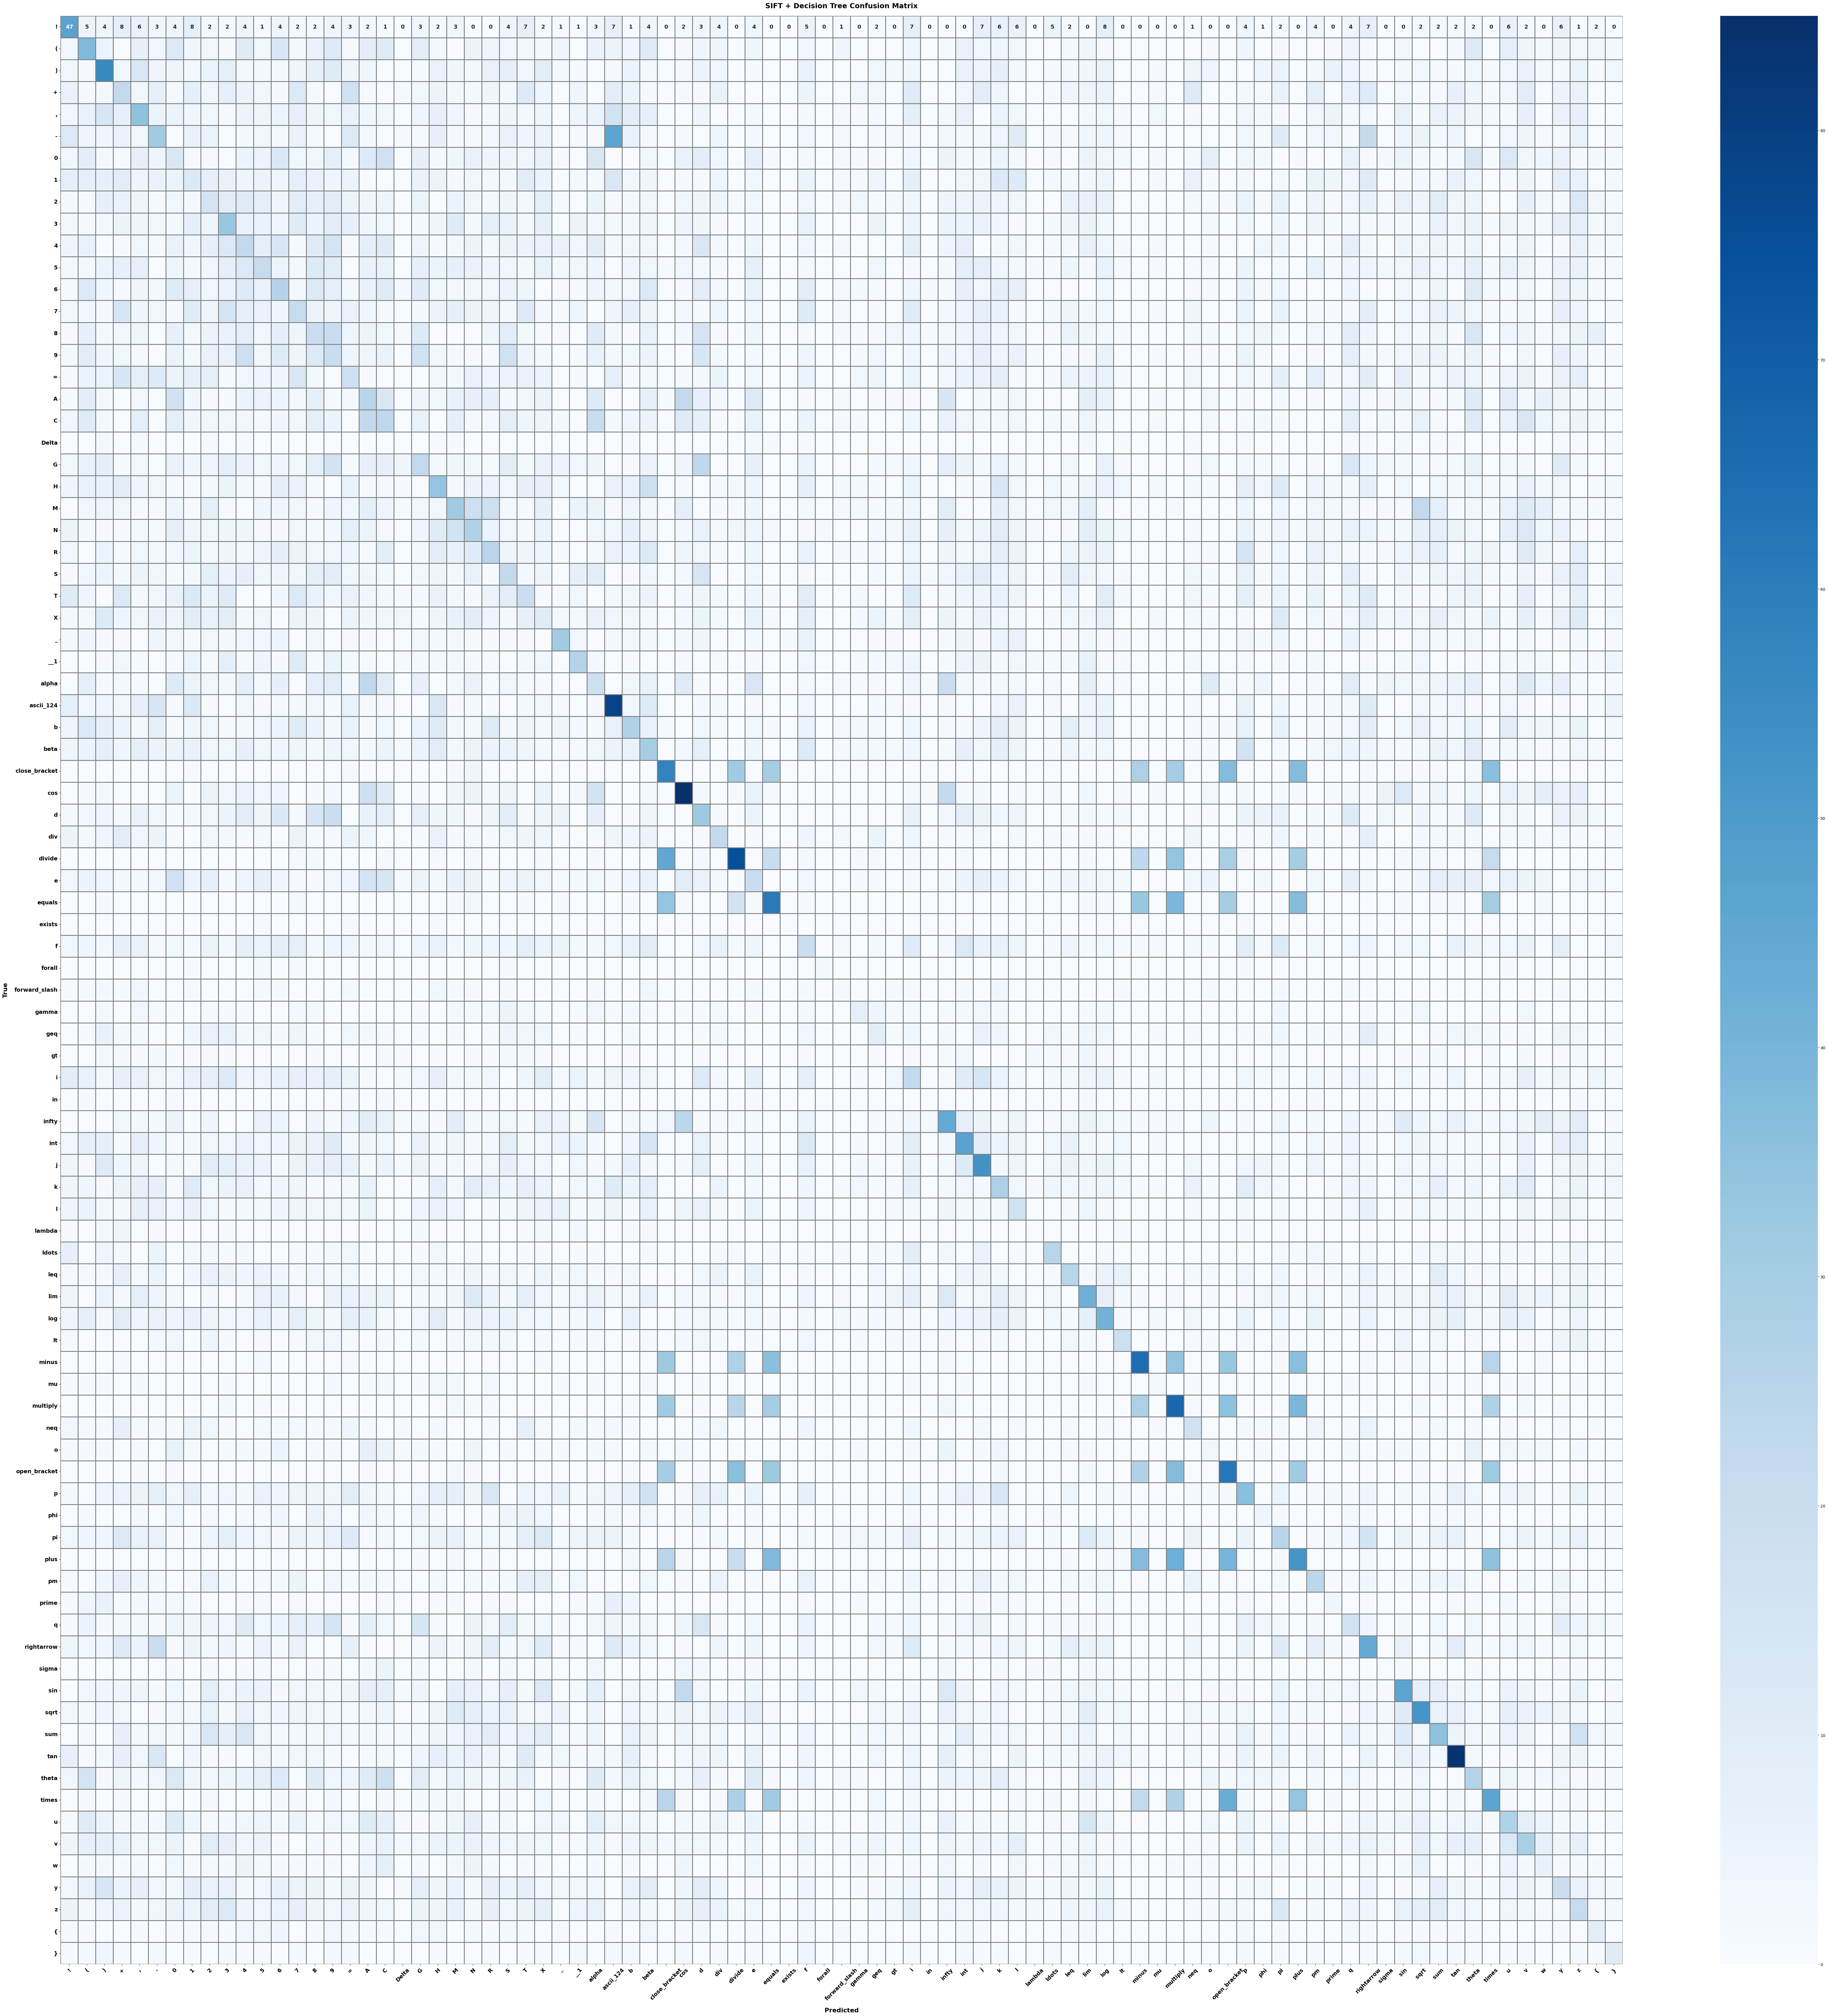

In [9]:
hog_acc = evaluate_model(X_train_hog, X_test_hog, y_train, y_test, "HOG", class_mapping)
glcm_acc = evaluate_model(X_train_glcm, X_test_glcm, y_train, y_test, "GLCM", class_mapping)
sift_acc = evaluate_model(X_train_sift, X_test_sift, y_train, y_test, "SIFT", class_mapping)


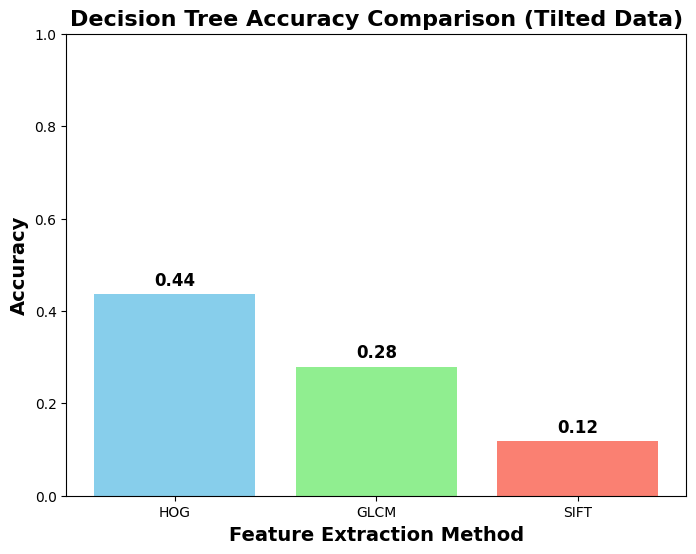

In [10]:
# Collect accuracies
dt_acc = {
    "HOG": hog_acc,
    "GLCM": glcm_acc,
    "SIFT": sift_acc
}

# Plot bar graph
plt.figure(figsize=(8,6))
plt.bar(dt_acc.keys(), dt_acc.values(), color=['skyblue', 'lightgreen', 'salmon'])
plt.title("Decision Tree Accuracy Comparison (Tilted Data)", fontsize=16, weight="bold")
plt.xlabel("Feature Extraction Method", fontsize=14, weight="bold")
plt.ylabel("Accuracy", fontsize=14, weight="bold")
plt.ylim(0, 1.0)
for i, v in enumerate(dt_acc.values()):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=12, weight="bold")
plt.show()



========== HOG + Random Forest ==========
Accuracy: 0.7805
Cohen's Kappa: 0.7775

Classification Report:
               precision    recall  f1-score   support

            !       0.89      0.90      0.90       260
            (       0.68      0.95      0.79       300
            )       0.67      0.89      0.77       300
            +       0.75      0.81      0.78       300
            ,       0.54      0.63      0.58       300
            -       0.89      0.97      0.93       300
            0       0.67      0.86      0.75       300
            1       0.57      0.37      0.45       300
            2       0.69      0.58      0.63       300
            3       0.72      0.74      0.73       300
            4       0.67      0.56      0.61       300
            5       0.75      0.64      0.69       300
            6       0.68      0.84      0.75       300
            7       0.78      0.80      0.79       300
            8       0.66      0.84      0.74       300
            9


========== GLCM + Random Forest ==========
Accuracy: 0.3740
Cohen's Kappa: 0.3654

Classification Report:
               precision    recall  f1-score   support

            !       0.78      0.86      0.82       260
            (       0.32      0.41      0.36       300
            )       0.42      0.56      0.48       300
            +       0.29      0.45      0.36       300
            ,       0.46      0.42      0.44       300
            -       0.92      0.97      0.94       300
            0       0.20      0.18      0.19       300
            1       0.25      0.16      0.20       300
            2       0.12      0.08      0.10       300
            3       0.16      0.18      0.17       300
            4       0.12      0.10      0.11       300
            5       0.14      0.11      0.13       300
            6       0.20      0.25      0.22       300
            7       0.19      0.21      0.20       300
            8       0.27      0.44      0.34       300
            


========== SIFT + Random Forest ==========
Accuracy: 0.2013
Cohen's Kappa: 0.1903

Classification Report:
               precision    recall  f1-score   support

            !       0.33      0.32      0.33       260
            (       0.11      0.25      0.15       300
            )       0.23      0.37      0.29       300
            +       0.11      0.15      0.13       300
            ,       0.21      0.25      0.23       300
            -       0.16      0.23      0.19       300
            0       0.07      0.06      0.07       300
            1       0.09      0.10      0.10       300
            2       0.07      0.05      0.06       300
            3       0.11      0.12      0.12       300
            4       0.16      0.21      0.18       300
            5       0.18      0.16      0.17       300
            6       0.12      0.15      0.14       300
            7       0.11      0.13      0.12       300
            8       0.14      0.19      0.16       300
            

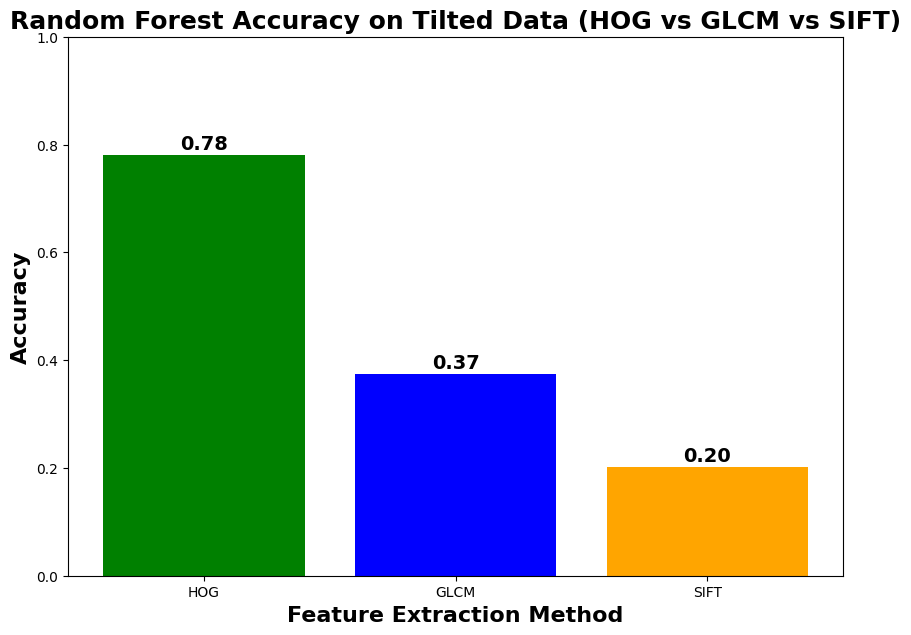

In [7]:
# -----------------------------
# RANDOM FOREST ON TILTED DATA
# -----------------------------

from sklearn.ensemble import RandomForestClassifier

# Evaluation function
def evaluate_rf_model(X_train, X_test, y_train, y_test, feature_name, class_mapping):
    print(f"\n========== {feature_name} + Random Forest ==========")

    model = RandomForestClassifier(
        n_estimators=100, random_state=42, n_jobs=-1
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}")
    print(f"Cohen's Kappa: {kappa:.4f}")

    # Classification Report
    unique_labels = np.unique(np.concatenate([y_test, y_pred]))
    print("\nClassification Report:")
    print(classification_report(
        y_test, y_pred,
        labels=unique_labels,
        target_names=[class_mapping[i] for i in unique_labels],
        zero_division=0
    ))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=unique_labels)
    num_classes = len(unique_labels)

    # Make figure size scale with number of classes
    fig_width = max(16, num_classes * 1.2)
    fig_height = max(14, num_classes * 1.2)

    plt.figure(figsize=(fig_width, fig_height))
    sns.heatmap(
        cm, annot=True, fmt='d', cmap="Greens",
        xticklabels=[class_mapping[i] for i in unique_labels],
        yticklabels=[class_mapping[i] for i in unique_labels],
        cbar=True, linewidths=1.8, linecolor='gray',
        annot_kws={"size": 20, "weight": "bold"}   # bigger numbers inside cells
    )
    plt.xticks(rotation=45, fontsize=18, weight="bold")
    plt.yticks(rotation=0, fontsize=18, weight="bold")
    plt.title(f"{feature_name} + Random Forest Confusion Matrix", fontsize=22, weight="bold", pad=20)
    plt.xlabel("Predicted", fontsize=20, weight="bold", labelpad=15)
    plt.ylabel("True", fontsize=20, weight="bold", labelpad=15)
    plt.tight_layout()
    plt.show()

    return acc


# Run RF evaluations on tilted dataset features
hog_acc_rf  = evaluate_rf_model(X_train_hog, X_test_hog, y_train, y_test, "HOG", class_mapping)
glcm_acc_rf = evaluate_rf_model(X_train_glcm, X_test_glcm, y_train, y_test, "GLCM", class_mapping)
sift_acc_rf = evaluate_rf_model(X_train_sift, X_test_sift, y_train, y_test, "SIFT", class_mapping)

# -----------------------------
# BAR GRAPH COMPARISON
# -----------------------------
acc_results_rf = {
    "HOG": hog_acc_rf,
    "GLCM": glcm_acc_rf,
    "SIFT": sift_acc_rf
}

plt.figure(figsize=(10, 7))
plt.bar(acc_results_rf.keys(), acc_results_rf.values(), color=["green", "blue", "orange"])
plt.title("Random Forest Accuracy on Tilted Data (HOG vs GLCM vs SIFT)", fontsize=18, weight="bold")
plt.xlabel("Feature Extraction Method", fontsize=16, weight="bold")
plt.ylabel("Accuracy", fontsize=16, weight="bold")
plt.ylim(0, 1)
for i, v in enumerate(acc_results_rf.values()):
    plt.text(i, v + 0.01, f"{v:.2f}", ha="center", fontsize=14, weight="bold")
plt.show()
